In [163]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [164]:
env = BlackjackEnv()

In [177]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    
    for i_episode in range(1,num_episodes+1):
        
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        state = env.reset()
        rewards = []
        observations = []
        # generate an episode trajectory
        for t in range(100):
            # take an action using current policy
            action = policy(state)
            new_state, reward, done, _ = env.step(action)
            
            rewards.append(reward)
            observations.append((state, action, reward))
            if done: 
                break 
            state = new_state
        '''
        G = 0.0
        T = len(observations)
        states = [observations[t][0] for t in range(T)]
        for t in reversed(range(T-1)):
            G = rewards[t+1] + discount_factor * G

            s = observations[t][0]
            # first-visit MC
            if s not in states[:t]:
                returns_sum[s] += G
                returns_count[s] += 1.0
                V[s] = returns_sum[s] / returns_count[s]
        '''
        visited_states = set([tuple(x[0]) for x in observations])
        for state in visited_states:
            # find first occurrence 
            first_idx = next(i for i,x in enumerate(observations) if x[0] == state)
            # sum rewards from that point
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(observations[first_idx:])])
            # add G, count to associated sums
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]
    #print (V)
    return V    

In [178]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

Episode 10000/10000.

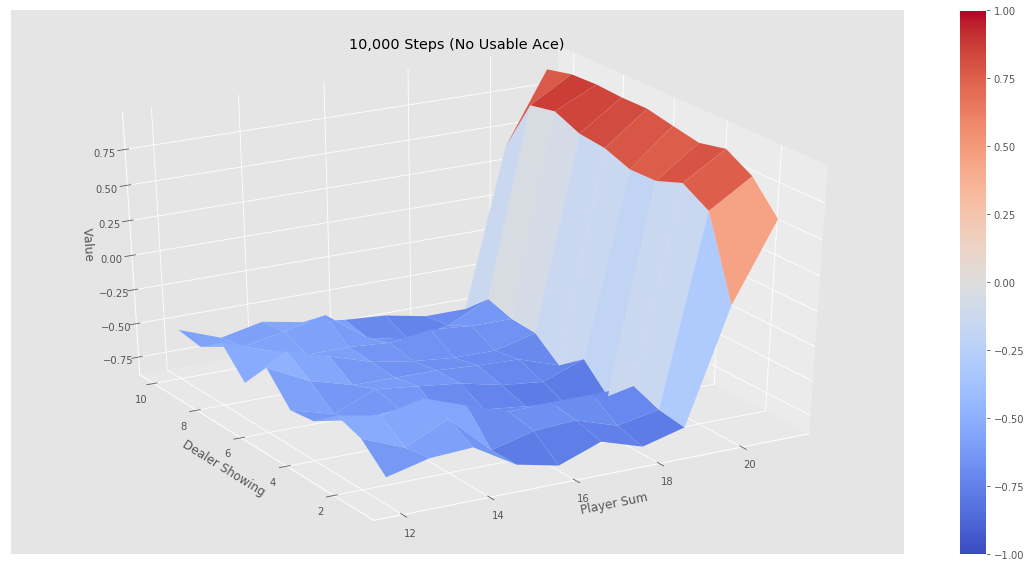

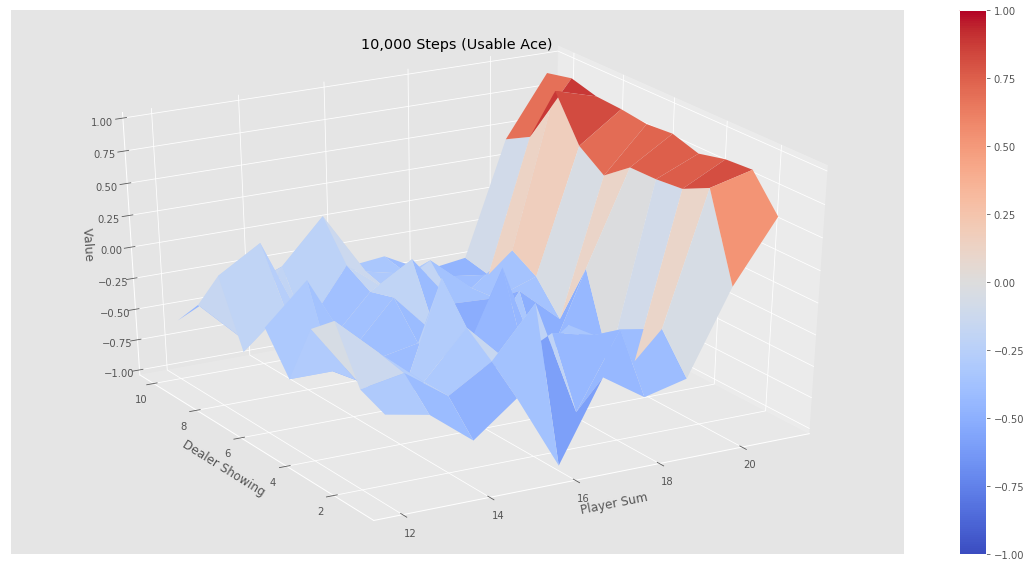

Episode 500000/500000.

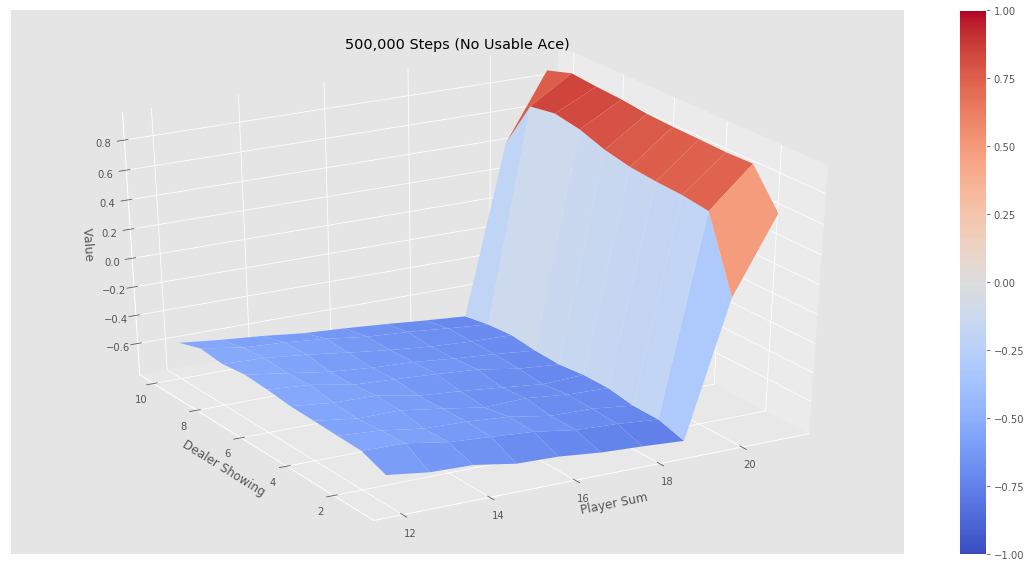

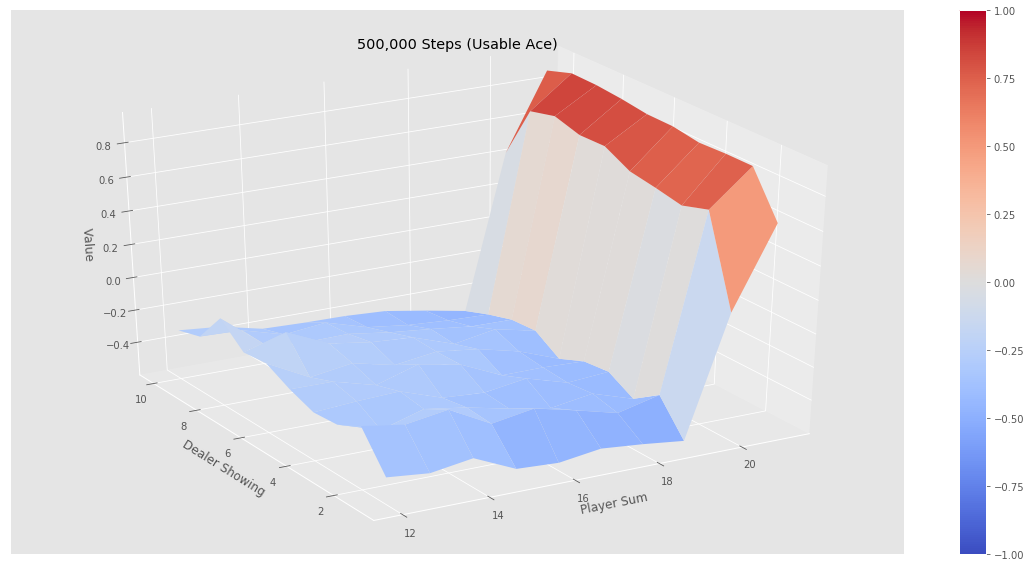

In [179]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")